In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
plt.style.use('default')
from pyfermions import *

/Users/michael/.local/share/virtualenvs/pyfermions/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Collect all relevant data to analyze the error term in our Theorem 1:

In [2]:
K_max = 10
L_max = 10
NUM_ITERATIONS = 15


def B(h, g):
    """Return infinity-norm bound on scaling functions."""
    x, phi_h = h.scaling_function(NUM_ITERATIONS)
    x, phi_g = g.scaling_function(NUM_ITERATIONS)
    return max(np.max(np.abs(phi_h)), np.max(np.abs(phi_g)))


def eps(h, g):
    k = np.linspace(-np.pi, np.pi, 1024)
    H_s = h.scaling_filter.ft(k)
    G_s = g.scaling_filter.ft(k)

    diff = np.abs(H_s - np.exp(1j * k / 2) * G_s)
    return np.max(diff)


data = {'K': [], 'L': [], 'M': [], 'B': [], 'eps': []}
for K in range(1, K_max + 1):
    for L in range(1, L_max + 1):
        h, g = selesnick_hwlet(K, L)
        data['K'].append(K)
        data['L'].append(L)
        data['M'].append(2 * (K + L))
        assert len(h.scaling_filter.range) == len(
            g.scaling_filter.range) == 2 * (K + L)
        data['B'].append(B(h, g))
        data['eps'].append(eps(h, g))

df = pd.DataFrame(data)
df

,K,L,M,B,eps
0,1,1,4,2.226577,0.264099
1,1,2,6,1.826444,0.115917
2,1,3,8,1.474978,0.057788
3,1,4,10,1.529166,0.030874
4,1,5,12,1.213573,0.017236
...,...,...,...,...,...
95,10,6,32,1.089618,0.000157
96,10,7,34,1.090395,0.000052
97,10,8,36,0.862696,0.000018
98,10,9,38,0.860961,0.000006


Verify that the scaling functions of $h$ and $g$ remain bounded for large $K$ and $L$.

In [3]:
B_max = df['B'].abs().max()
B_max

2.2265770750064395

Verify that the error $\varepsilon$ decreases exponentially as we increase $K,L$:

In [4]:
errors = pd.pivot_table(df, values='eps', index=['K'], columns=['L'])
errors

L,1,2,3,4,5,6,7,8,9,10
K,,,,,,,,,,
1,0.264099,0.115917,0.057788,0.030874,0.017236,0.009920,0.005840,0.003497,0.002124,0.001304
2,0.196316,0.068221,0.028116,0.012812,0.006240,0.003187,0.001686,0.000918,0.000511,0.000289
3,0.171760,0.051170,0.018338,0.007379,0.003215,0.001485,0.000718,0.000359,0.000185,0.000098
4,0.159785,0.042731,0.013774,0.005020,0.001996,0.000847,0.000378,0.000176,0.000085,0.000042
5,0.153045,0.037800,0.011217,0.003772,0.001389,0.000548,0.000229,0.000100,0.000045,0.000021
6,0.148938,0.034614,0.009613,0.003024,0.001044,0.000387,0.000152,0.000063,0.000027,0.000012
7,0.146314,0.032412,0.008526,0.002536,0.000828,0.000291,0.000108,0.000042,0.000017,0.000007
8,0.144590,0.030815,0.007748,0.002197,0.000684,0.000229,0.000081,0.000030,0.000012,0.000005
9,0.143447,0.029615,0.007168,0.001951,0.000582,0.000187,0.000064,0.000023,0.000009,0.000003


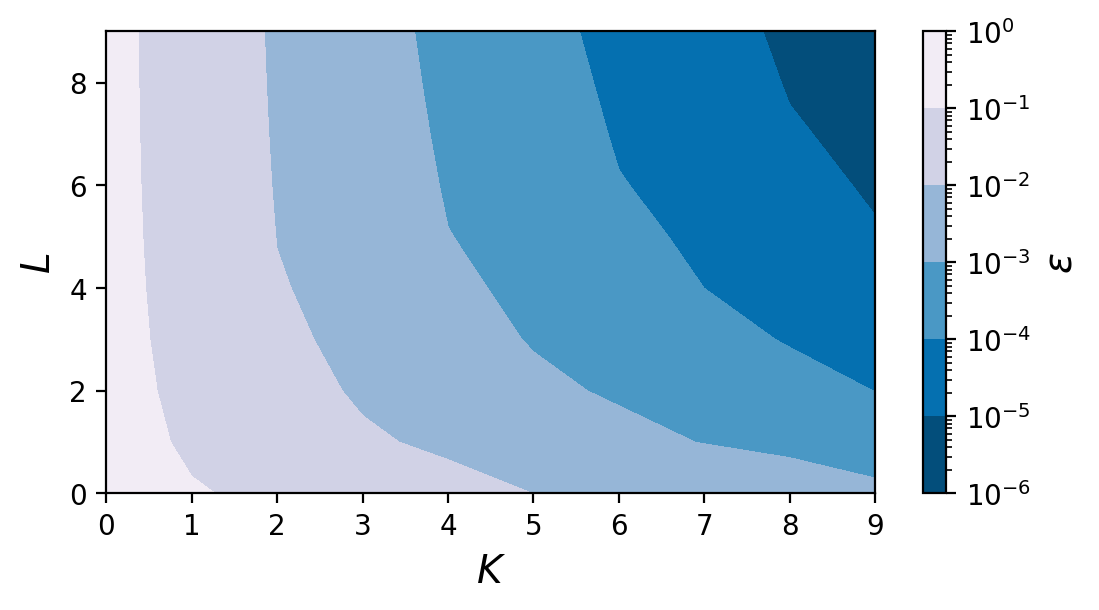

In [5]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(6.2, 3))
plt.contourf(errors, norm=LogNorm(), cmap='PuBu_r')
plt.xlabel('$K$', fontsize=14)
plt.ylabel('$L$', fontsize=14)
plt.colorbar().set_label(label=r'$\varepsilon$', size=14)

plt.savefig('epsilon_errors.pdf', bbox_inches='tight')

Find exponential fit for $K=L$:

-1.8521858671474651 -0.17821190759824113


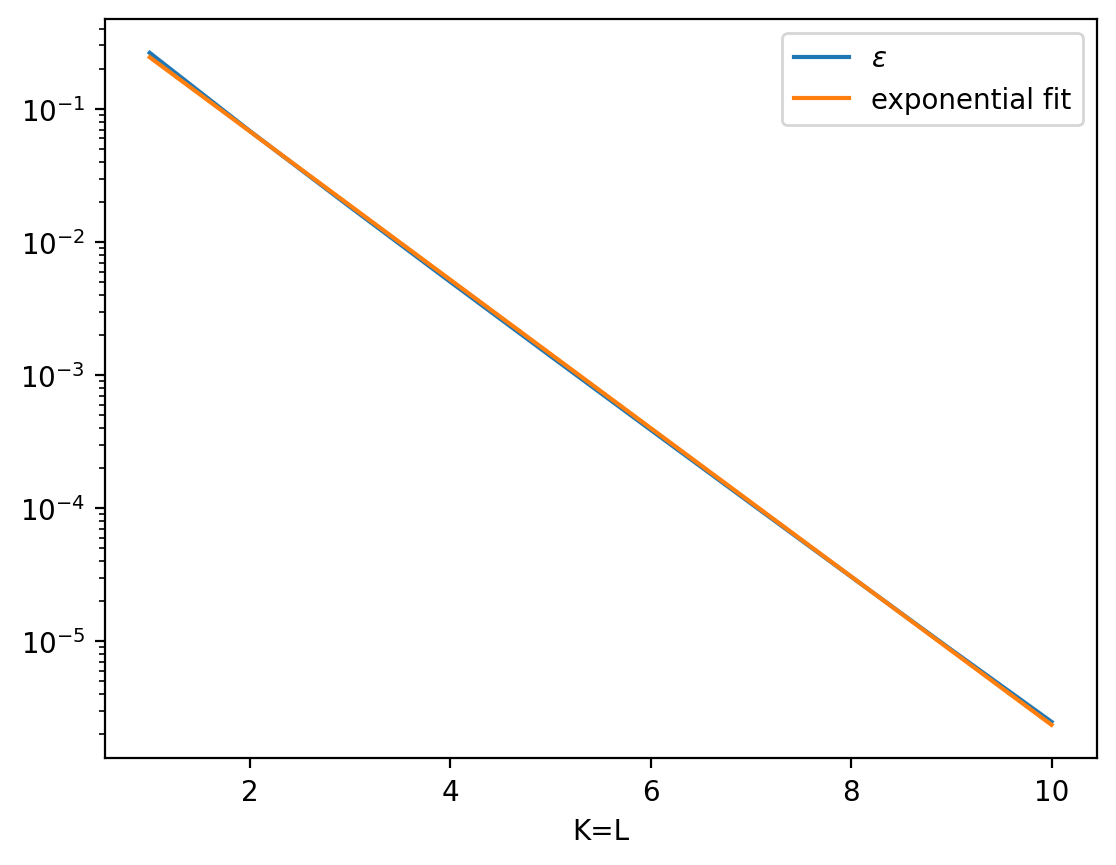

In [6]:
df_KL = df[df['K'] == df['L']]
K = df_KL['K']

# exponential fit
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    K, np.log2(df_KL['eps']))
print(slope, intercept)

plt.figure()
plt.semilogy(K, df_KL['eps'], label=r'$\varepsilon$')
plt.semilogy(K, 2**(slope * K + intercept), '-', label='exponential fit')
plt.legend()
plt.xlabel('K=L')
plt.show()

Plot the *a priori* error bound for the energy density for a 2-point function (if we choose $K=L$ and $S=20+K$):

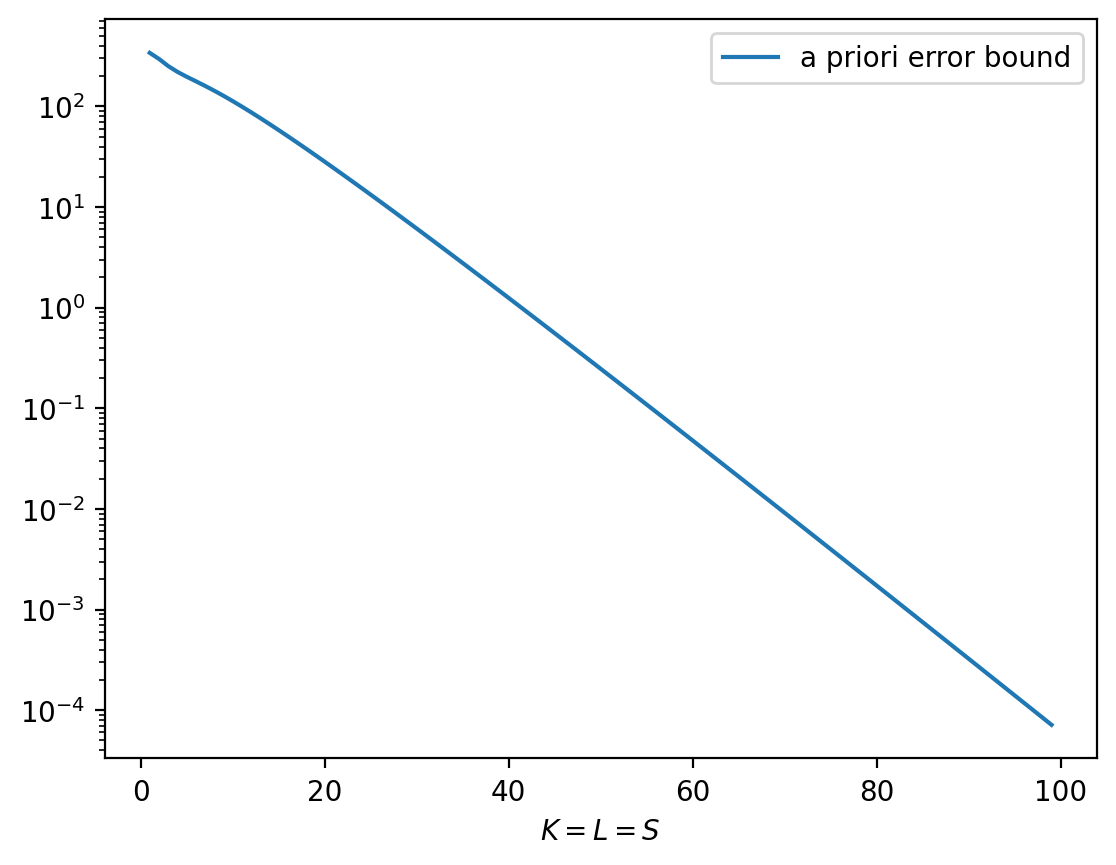

In [7]:
def n_point_error(n, S, B, M, eps):
    C = 2**(3 / 2) * np.sqrt(n) * B * M
    return 24 * np.sqrt(n) * np.sqrt(C * 2**
                                     (-S / 2) + 6 * eps * np.log2(C / eps)**2)


K = L = S = np.arange(1, 100)
eps = 2**(slope * K + intercept)
error = n_point_error(n=2, S=S, B=B_max, M=2 * (K + L), eps=eps)

plt.figure()
plt.semilogy(K, error, label='a priori error bound')
plt.legend()
plt.xlabel('$K=L=S$')
plt.show()

This is of course terribly pessimistic.